In [37]:
%load_ext autoreload
%autoreload 2


import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc
import cstrees.cstree as ct

import matplotlib.pyplot as plt

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# CStree from Figure 1 in (Duarte & Solus, 2022)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
np.random.seed(2)
p=4
cards = [2] * p
co = ct.CausalOrder(range(p))
tree = ct.CStree(co)


#stage = ct.sample_random_stage(cards,2)
#stage.set_random_params(cards)

tree.set_cardinalities(cards)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.

tree.set_stages({
    0: [],
    1: [ct.Stage([{0, 1}, 0])],    # Green
    2: [ct.Stage([0, {0, 1}, 0]),  # Blue
        ct.Stage([0, {0, 1}, 1]),  # Orange
        ct.Stage([1, {0, 1}, 0])]  # Red
})


tree.set_random_stage_parameters()


a = tree.plot()
a.draw("testplot.png")
x = tree.sample(5)

#x = tree.sample(5)
print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")
print(s)
#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs()

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

0 []
1 [<cstrees.cstree.Stage object at 0x7fb8097f4d00>]
2 [<cstrees.cstree.Stage object at 0x7fb8097f4eb0>, <cstrees.cstree.Stage object at 0x7fb8097f4a60>, <cstrees.cstree.Stage object at 0x7fb8097f48e0>]
3 []


KeyError: 'cond_prob'

0 [<cstrees.cstree.Stage object at 0x7fb7f8631400>, <cstrees.cstree.Stage object at 0x7fb7f8631580>]
1 [<cstrees.cstree.Stage object at 0x7fb7f85a4b50>]
2 [<cstrees.cstree.Stage object at 0x7fb7f85a4f10>, <cstrees.cstree.Stage object at 0x7fb808aff790>]
3 []
-1 [<cstrees.cstree.Stage object at 0x7fb7f8631280>]


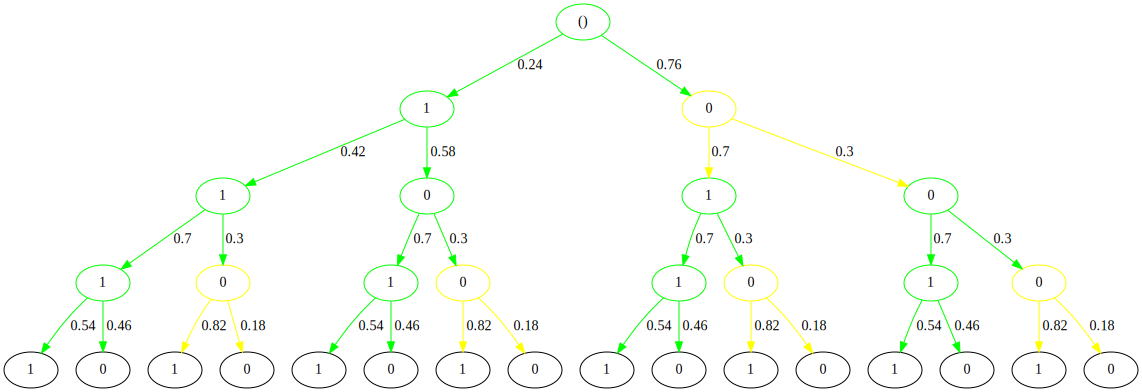

In [93]:
np.random.seed(6)
t = ct.sample_cstree(cards, max_cvars=1, prob_cvar=0.5, prop_nonsingleton=1)
t.set_random_stage_parameters()
t.create_tree()
t.set_random_parameters()
a = t.plot()
x = t.sample(2000)
#plt.savefig("testplot.png")
a

Level 0
[0] {0: 466, 1: 1094}
[1] {0: 247, 1: 193}
Level 1
[{0, 1}, {0, 1}] {0: 632, 1: 1368}
Level 2
[{0, 1}, {0, 1}, 0] {1: 509, 0: 123}
[{0, 1}, {0, 1}, 1] {0: 665, 1: 703}
Level 3
Level -1
[] {0: 1560, 1: 440}


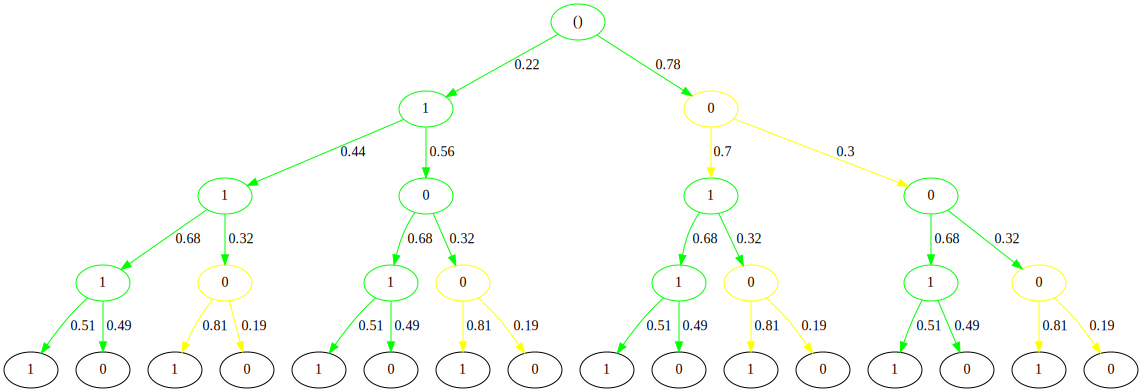

In [113]:
t.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
t.create_tree()
t.set_random_parameters()
a = t.plot()
a


In [116]:
order = [0, 1, 2, 3]
opttree = ct.optimal_cstree(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
#print("stages :{}".format(opttree.stages))
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
#opttree.create_tree()
#opttree.set_random_parameters()
#opttree.plot()


max staging: ['[]']
max staging: ['[0]', '[1]']
max staging: ['[{0, 1}, 0]', '[{0, 1}, 1]']
Level 0
[] {0: 713, 1: 1287}
Level 1
[0] {0: 489, 1: 1071}
[1] {1: 297, 0: 143}
Level 2
[{0, 1}, 0] {1: 437, 0: 276}
[{0, 1}, 1] {1: 775, 0: 512}
Level 3
Level -1
[] {0: 1560, 1: 440}


In [ ]:

order = [0, 1, 2, 3]
score = sc.score_order(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(score)
 

In [ ]:
stagings = ct.all_stagings(order, cards, level, max_cvars=1)
print("#Stagings")
nst = ct.n_stagings(order, cards, level, max_cvars=1)
print(nst)
print("Stagings")
for ss in stagings:
    for s in ss:
        print(s)

In [ ]:
for l in range(len(order)):
    max_staging, max_score = ct.optimal_staging_at_level(order, cards, x, l, max_cvars=1, alpha_tot=1.0, method="BDeu")
    print("best staging at level {}".format(l))
    print(max_score)   
    for st in max_staging:
        print(st)

    